In [1]:
import numpy as np
import os

In [2]:
def load_data(train = True):
    """
    Load the data from disk
    Parameters
    ----------
    train : bool
        Load training data if true, else load test data
    Returns
    -------
        Tuple:
            Images
            Labels
    """
    directory = 'train' if train else 'test'
    patterns = np.load(os.path.join('./data/', directory, 'images.npz'))['arr_0']
    labels = np.load(os.path.join('./data/', directory, 'labels.npz'))['arr_0']
    return patterns.reshape(len(patterns), -1), labels

In [3]:
def generate_minibatches(dataset, batch_size=64):
    X, y = dataset
    l_idx, r_idx = 0, batch_size
    while r_idx < len(X):
        yield X[l_idx:r_idx], y[l_idx:r_idx]
        l_idx, r_idx = r_idx, r_idx + batch_size

    yield X[l_idx:], y[l_idx:]

def generate_k_fold_set(dataset, k = 10): 
    X, y = dataset

    order = np.random.permutation(len(X))
    
    fold_width = len(X) // k

    l_idx, r_idx = 0, fold_width

    for i in range(k):
        train = np.concatenate([X[order[:l_idx]], X[order[r_idx:]]]), np.concatenate([y[order[:l_idx]], y[order[r_idx:]]])
        validation = X[order[l_idx:r_idx]], y[order[l_idx:r_idx]]
        yield train, validation
        l_idx, r_idx = r_idx, r_idx + fold_width

In [4]:
train=load_data(train = True)
test=load_data(train = False)

In [5]:
def z_score_normalize(X, u = None, xd = None):
    """
    Performs z-score normalization on X. 
    f(x) = (x - μ) / σ
        where 
            μ = mean of x
            σ = standard deviation of x
    Parameters
    ----------
    X : np.array
        The data to z-score normalize
    u (optional) : np.array
        The mean to use when normalizing
    sd (optional) : np.array
        The standard deviation to use when normalizing
    Returns
    -------
        Tuple:
            Transformed dataset with mean 0 and stdev 1
            Computed statistics (mean and stdev) for the dataset to undo z-scoring.
    """
    if u == None:
        mean=np.mean(X, axis=0)
    else:
        mean=u
    if xd==None:
        std=np.std(X, axis=0)
    else:
        std=xd
        
    X = (X - mean) / std
    
    return (X,mean,std)

In [6]:
def min_max_normalize(X, _min = None, _max = None):
    """
    Performs min-max normalization on X. 
    f(x) = (x - min(x)) / (max(x) - min(x))
    Parameters
    ----------
    X : np.array
        The data to min-max normalize
    _min (optional) : np.array
        The min to use when normalizing
    _max (optional) : np.array
        The max to use when normalizing
    Returns
    -------
        Tuple:
            Transformed dataset with all values in [0,1]
            Computed statistics (min and max) for the dataset to undo min-max normalization.
    """
    if _min == None:
        _min=np.min(X,axis=0)
    if _max == None:
        _max=np.max(X,axis=0)

        
    X= (X-_min)/(_max - _min)
    
    return (X,_min,_max)

In [7]:
def onehot_encode(y):
    """
    Performs one-hot encoding on y.
    Ideas:
        NumPy's `eye` function
    Parameters
    ----------
    y : np.array
        1d array (length n) of targets (k)
    Returns
    -------
        2d array (shape n*k) with each row corresponding to a one-hot encoded version of the original value.
    """
    #determine if y is two-class
    if len(np.unique(y))>2:
        values = y
        n_values = np.max(values) + 1
        return np.eye(n_values)[values] 
    else:
        value = np.max(y)
        return (y == value).astype(int).reshape(len(y),1) 

In [8]:
def shuffle(dataset):
    """
    Shuffle dataset.
    Make sure that corresponding images and labels are kept together. 
    Ideas: 
        NumPy array indexing 
            https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing
    Parameters
    ----------
    dataset
        Tuple containing
            Images (X)
            Labels (y)
    Returns
    -------
        Tuple containing
            Images (X)
            Labels (y)
    """
    dim=dataset[0].shape[0]
    index1=np.arange(dim)
    np.random.shuffle(index1)
    shuffled_data=dataset[0][index1]
    shuffled_label=dataset[1][index1]
    return (shuffled_data,shuffled_label)

In [9]:
def append_bias(X):
    """
    Append bias term for dataset.
    Parameters
    ----------
    X
        2d numpy array with shape (N,d)
    Returns
    -------
        2d numpy array with shape ((N+1),d)
    """
    new=np.ones((X.shape[0],X.shape[1]+1))
    new[:,:-1] = X
    return new

In [109]:
def sigmoid(a):
    """
    Compute the sigmoid function.

    f(x) = 1 / (1 + e ^ (-x))

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying sigmoid (z from the slides).
    """
    clipped=[]
    a=a.flatten()
    #clipping the data
    for i in range(len(a)):
        if a[i]>20:
            clipped.append(20)
        elif a[i]<-20:
            clipped.append(-20)
        else:
            clipped.append(a[i])
    clipped=np.array(clipped)
    return 1/(1+np.exp(-clipped))

def softmax(a):
    """
    Compute the softmax function.

    f(x) = (e^x) / Σ (e^x)

    Parameters
    ----------
    a
        The internal value while a pattern goes through the network
    Returns
    -------
    float
       Value after applying softmax (z from the slides).
    """
    #clipping the data
    a=np.clip(a,-20,20)
#     #calculate sum of 
#     denominator=0
#     for i in range(a.shape[1]):
#         denominator+=np.exp(a[:,i])
#     result=[]
#     for i in range(a.shape[1]):
#         result.append(np.exp(a[:,i])/denominator)
        
#     return np.array(result).T
    a_exp = np.exp(a)
    partition = np.sum(a_exp, axis=1).reshape(-1,1)
    return a_exp / partition

def binary_cross_entropy(y, t):
    """
    Compute binary cross entropy.

    L(x) = t*ln(y) + (1-t)*ln(1-y)

    Parameters
    ----------
    y
        The network's predictions
    t
        The corresponding targets
    Returns
    -------
    float 
        binary cross entropy loss value according to above definition
    """
    vectorized=t*np.log(y)+(1-t)*np.log(1-y)
    return -np.mean(vectorized)

def multiclass_cross_entropy(y, t):
    """
    Compute multiclass cross entropy.

    L(x) = - Σ (t*ln(y))

    Parameters
    ----------
    y
        The network's predictions
    t
        The corresponding targets
    Returns
    -------
    float 
        multiclass cross entropy loss value according to above definition
    """
    entropy=np.zeros(t.shape[0])
    #calculate multi-class cross entropy
    for i in range(10):
        target_column=t[:,i]
        prediction_column=y[:,i]
        entropy+=target_column*np.log(prediction_column)
    return -np.mean(entropy/10)

class Network:
    def __init__(self, hyperparameters, activation, loss, out_dim):
        """
        Perform required setup for the network.

        Initialize the weight matrix, set the activation function, save hyperparameters.

        You may want to create arrays to save the loss values during training.

        Parameters
        ----------
        hyperparameters
            A Namespace object from `argparse` containing the hyperparameters
        activation
            The non-linear activation function to use for the network
        loss
            The loss function to use while training and testing
        """
        self.hyperparameters = hyperparameters
        self.activation = activation
        self.loss = loss
        self.out_dim=out_dim

        self.weights = np.zeros((28*28+1, out_dim))

    def forward(self, X):
        """
        Apply the model to the given patterns

        Use `self.weights` and `self.activation` to compute the network's output

        f(x) = σ(w*x)
            where
                σ = non-linear activation function
                w = weight matrix

        Make sure you are using matrix multiplication when you vectorize your code!

        Parameters
        ----------
        X
            Patterns to create outputs for
            
        """
        product=np.matmul(X,self.weights)
        return self.activation(product)

    def __call__(self, X):
        return self.forward(X)

    def train(self, minibatch):
        """
        Train the network on the given minibatch

        Use `self.weights` and `self.activation` to compute the network's output
        Use `self.loss` and the gradient defined in the slides to update the network.

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
        tuple containing:
            average loss over minibatch
            accuracy over minibatch
        """
        X, y = minibatch
        
        # To train the model, we have several things to do:
        # We will read of the learning rate, and bath size.
        # Then, based on the specification of the user,normalize the data.
        
        learning_rate=self.hyperparameters[0]
        batch_size_x=self.hyperparameters[1]
        
        X,mean_X,std_X=self.hyperparameters[2](X) # data Normalization and append bias 
        X=append_bias(X)
        
        
        dataset=(X,y)
        
        # Keep track of our model performance over epoches 
        accuracies_10= []
        training_losses_10 = []
        validation_losses_10=[]
        val_accuracies_10=[]
        
        for training, validation in generate_k_fold_set(dataset):
            
            self.weights = np.zeros((28*28+1, self.out_dim))
            
            #Keep track of the statistics for the single val process
            accuracies = []
            training_losses = []
            validation_losses=[]
            val_accuracies=[]
            
            # train our model with maximum 100 epoches allowed 
            for epoch in range(20):
                training=shuffle(training)
                # Generate mini_bathch with specified 
                for X_train,y_train in generate_minibatches(training,batch_size=batch_size_x):

                    # Compute the output of our model with given weight
                    # This should output a 10*data_size matrix, 
                    # where each column represents probability distribution

                    predictions=self.forward(X_train).reshape((-1,self.out_dim))
                    
                    
    
                    # One-hot encode the labels for which we can compute the error rate 
                    # Notice that the dimension of the one-hot encoded target is datasize*10
                    target=onehot_encode(y_train).reshape((-1,self.out_dim))
                    
                    
                    
                    error_signal=(target-predictions)
                    
        
            
                    gradient=-1*(np.matmul(error_signal.T,X_train))
                    
                    
                    if self.activation==sigmoid:
                        gradient=gradient.flatten().reshape((-1,self.out_dim))

                        # Upadte the weight matrix with gradient descent

                        self.weights=self.weights-learning_rate*gradient
                    else:
                        self.weights=self.weights-learning_rate*gradient.T
                          

                # Evaluate our model's performance at the end of each epoches
                # Evaluate at the entire training dataset.
                #print(training[0])
                prediction_epoch=self.forward(training[0])
                
                if self.activation==softmax:
                    encoded_target=onehot_encode(training[1])
                    training_losses_n=multiclass_cross_entropy(prediction_epoch,encoded_target)
                    training_losses.append(training_losses_n)
                    # compute the accuracy
                    predicted_labels=np.argmax(prediction_epoch,axis=1)
                    #print(predicted_labels)
                    labels=np.argmax(encoded_target,axis=1)
                    single_accuracy=np.mean(predicted_labels==labels)
                    #print(single_accuracy)
                    accuracies.append(single_accuracy)
                else:
                    encoded_target=onehot_encode(training[1]).flatten()
                    training_losses_n=binary_cross_entropy(prediction_epoch,encoded_target)
                    training_losses.append(training_losses_n)
                    #print(training_losses_n)
                    # compute the accuracy 
                    predicted_labels=1*(prediction_epoch>0.5)
                    single_accuracy=np.mean(predicted_labels==encoded_target)
                    accuracies.append(single_accuracy)
                    
                # Keep track of the validation losses 
                val_predict=self.forward(validation[0])

                if self.activation==softmax:
                    encoded_val_target=onehot_encode(validation[1])
                    val_losses=multiclass_cross_entropy(val_predict,encoded_val_target)
                    validation_losses.append(val_losses)
                    # compute the accuracy
                    predicted_labels_val=np.argmax(val_predict,axis=1)
                    labels_val=np.argmax(encoded_val_target,axis=1)
                    single_accuracy_val=np.mean(predicted_labels_val==labels_val)
                    print(single_accuracy_val)
                    val_accuracies.append(single_accuracy_val)
                else:
                    encoded_val_target=onehot_encode(validation[1]).flatten()
                    val_losses=binary_cross_entropy(val_predict,encoded_val_target)
                    validation_losses.append(val_losses) 
                    predicted_labels_val=1*(val_predict>0.5).flatten()
                    single_accuracy_val=np.mean(predicted_labels_val==encoded_val_target)
                    #print(single_accuracy_val)
                    val_accuracies.append(single_accuracy_val)
                    
                
            accuracies_10.append(accuracies)
            training_losses_10.append(training_losses)
            validation_losses_10.append(validation_losses)
            val_accuracies_10.append(val_accuracies)    
            
        return accuracies_10,training_losses_10,validation_losses_10,val_accuracies_10
                

    def test(self, minibatch):
        """
        Test the network on the given minibatch

        Use `self.weights` and `self.activation` to compute the network's output
        Use `self.loss` to compute the loss.
        Do NOT update the weights in this method!

        Parameters
        ----------
        minibatch
            The minibatch to iterate over

        Returns
        -------
            tuple containing:
                average loss over minibatch
                accuracy over minibatch
        """
        X, y = minibatch
        # Remember to normalize the data and append bias 
        X,mean_X,std_X=self.hyperparameters[2](X)
        X=append_bias(X)
        prediction_test=self.forward(X)
        accuracy=None
        losses=None
        
        if self.activation==softmax:
            encoded_target=onehot_encode(y)
            losses=multiclass_cross_entropy(prediction_test,encoded_target)
            # compute the accuracy
            predicted_labels_test=np.argmax(prediction_test,axis=1)
            labels_test=np.argmax(encoded_target,axis=1)
            accuracy=np.mean(predicted_labels_test==labels_test)
        else:
            encoded_target=onehot_encode(y).flatten()
            losses=binary_cross_entropy(prediction_test,encoded_target)
            # compute the accuracy 
            predicted_labels_test=1*(prediction_test>0.5)
            accuracy=np.mean(predicted_labels_test==encoded_target)
        return accuracy,losses,self.weights

In [110]:
hyperparameters_1=[0.001,300,z_score_normalize]
hyperparameters_2=[0.01,300,min_max_normalize]

In [24]:
# Just for logistic regression 
data_0=train[0][train[1]==2]
labels_0=train[1][train[1]==2]
data_6=train[0][train[1]==6]
labels_6=train[1][train[1]==6]
test_0=test[0][test[1]==2]
test_labels_0=test[1][test[1]==2]
test_6=test[0][test[1]==6]
test_labels_6=test[1][test[1]==6]

In [25]:
data_logistic=np.array(list(data_0)+list(data_6))
label_logistic=np.array(list(labels_0)+list(labels_6))
logistic_dataset=(data_logistic,label_logistic)
test_logistic=np.array(list(test_0)+list(test_6))
test_label_logistic=np.array(list(test_labels_0)+list(test_labels_6))
logistic_test=(test_logistic,test_label_logistic)

In [26]:
logistic_regression=Network([0.001,64,z_score_normalize],sigmoid, binary_cross_entropy,1)

In [27]:
at1,lt1,lv1,av1 = logistic_regression.train(logistic_test)

In [28]:
at1,lt1,lv1,av1 = np.array(at1).flatten(),np.array(lt1).flatten(),np.array(lv1).flatten(),np.array(av1).flatten()


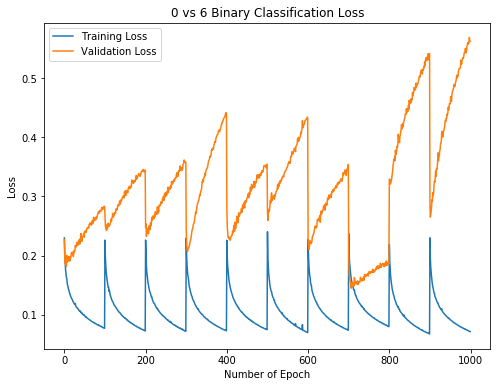

In [29]:
import matplotlib.pyplot as plt
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(8, 6),)
ax.plot(lt1,label='Training Loss')  # Plot some data on the axes.
ax.plot(lv1, label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Loss')  # Add a y-label to the axes.
ax.set_title("0 vs 6 Binary Classification Loss")  # Add a title to the axes.
ax.legend();  # Add a legend.

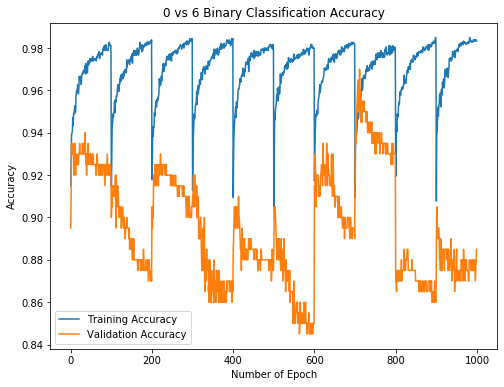

In [30]:
import matplotlib.pyplot as plt
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(8, 6),)
ax.plot(at1,label='Training Accuracy')  # Plot some data on the axes.
ax.plot(av1, label='Validation Accuracy')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("0 vs 6 Binary Classification Accuracy")  # Add a title to the axes.
ax.legend();  # Add a legend.

In [31]:
logistic_regression.test(logistic_test)

(0.9735,
 0.12071368510331108,
 array([[-1.60546570e-02],
        [-1.36961258e-01],
        [ 1.49348055e-01],
        [ 2.63116133e-04],
        [-1.17843720e-01],
        [ 1.16086633e-01],
        [ 6.00256432e-02],
        [ 7.86180102e-02],
        [-8.07718900e-03],
        [ 8.49459761e-02],
        [-1.36400628e-01],
        [-6.81785206e-02],
        [ 3.17262807e-02],
        [-1.66601345e-02],
        [ 1.27328794e-01],
        [ 5.03881277e-01],
        [-1.37863814e-01],
        [-9.00335320e-02],
        [-1.57663000e-01],
        [-2.10669011e-01],
        [ 3.26743567e-02],
        [-1.09411866e-01],
        [-8.50028193e-02],
        [ 4.47073428e-03],
        [-3.61791934e-02],
        [-5.11076202e-02],
        [ 5.51348348e-03],
        [ 3.24288186e-02],
        [-4.40434518e-02],
        [-1.14683658e-01],
        [ 8.44168412e-02],
        [ 6.53199918e-02],
        [-1.82383606e-01],
        [ 1.09321994e-01],
        [-9.22248046e-02],
        [ 9.28916286e-02

In [111]:
softmax_regression=Network([0.0001,300,z_score_normalize],softmax, multiclass_cross_entropy,10)

In [112]:
at,lt,lv,av =softmax_regression.train(train)

0.8125
0.8215
0.8218333333333333
0.8226666666666667
0.8255
0.8258333333333333
0.8251666666666667
0.825
0.8241666666666667
0.8265
0.8251666666666667
0.8255
0.8271666666666667
0.8251666666666667
0.825
0.8258333333333333
0.8248333333333333
0.8235
0.8255
0.8233333333333334
0.7995
0.8136666666666666
0.8163333333333334
0.8161666666666667
0.8178333333333333
0.8186666666666667
0.8198333333333333
0.8191666666666667
0.8186666666666667
0.8211666666666667
0.8221666666666667
0.821
0.8218333333333333
0.8211666666666667
0.8225
0.8213333333333334
0.8213333333333334
0.8226666666666667
0.8216666666666667
0.823
0.8075
0.8145
0.8181666666666667
0.8178333333333333
0.8185
0.819
0.8208333333333333
0.82
0.8235
0.8235
0.822
0.8225
0.8211666666666667
0.8235
0.8216666666666667
0.822
0.8216666666666667
0.8216666666666667
0.822
0.8215
0.8
0.8078333333333333
0.8113333333333334
0.8128333333333333
0.811
0.8141666666666667
0.8158333333333333
0.8161666666666667
0.8183333333333334
0.8176666666666667
0.8178333333333333
0

In [113]:
at,lt,lv,av = np.array(at).flatten(),np.array(lt).flatten(),np.array(lv).flatten(),np.array(av).flatten()

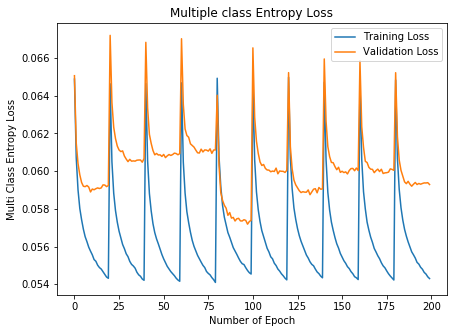

In [114]:
import matplotlib.pyplot as plt
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(7, 5),)
ax.plot(lt[:],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[:], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Multi Class Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Multiple class Entropy Loss")  # Add a title to the axes.
ax.legend();  # Add a legend.

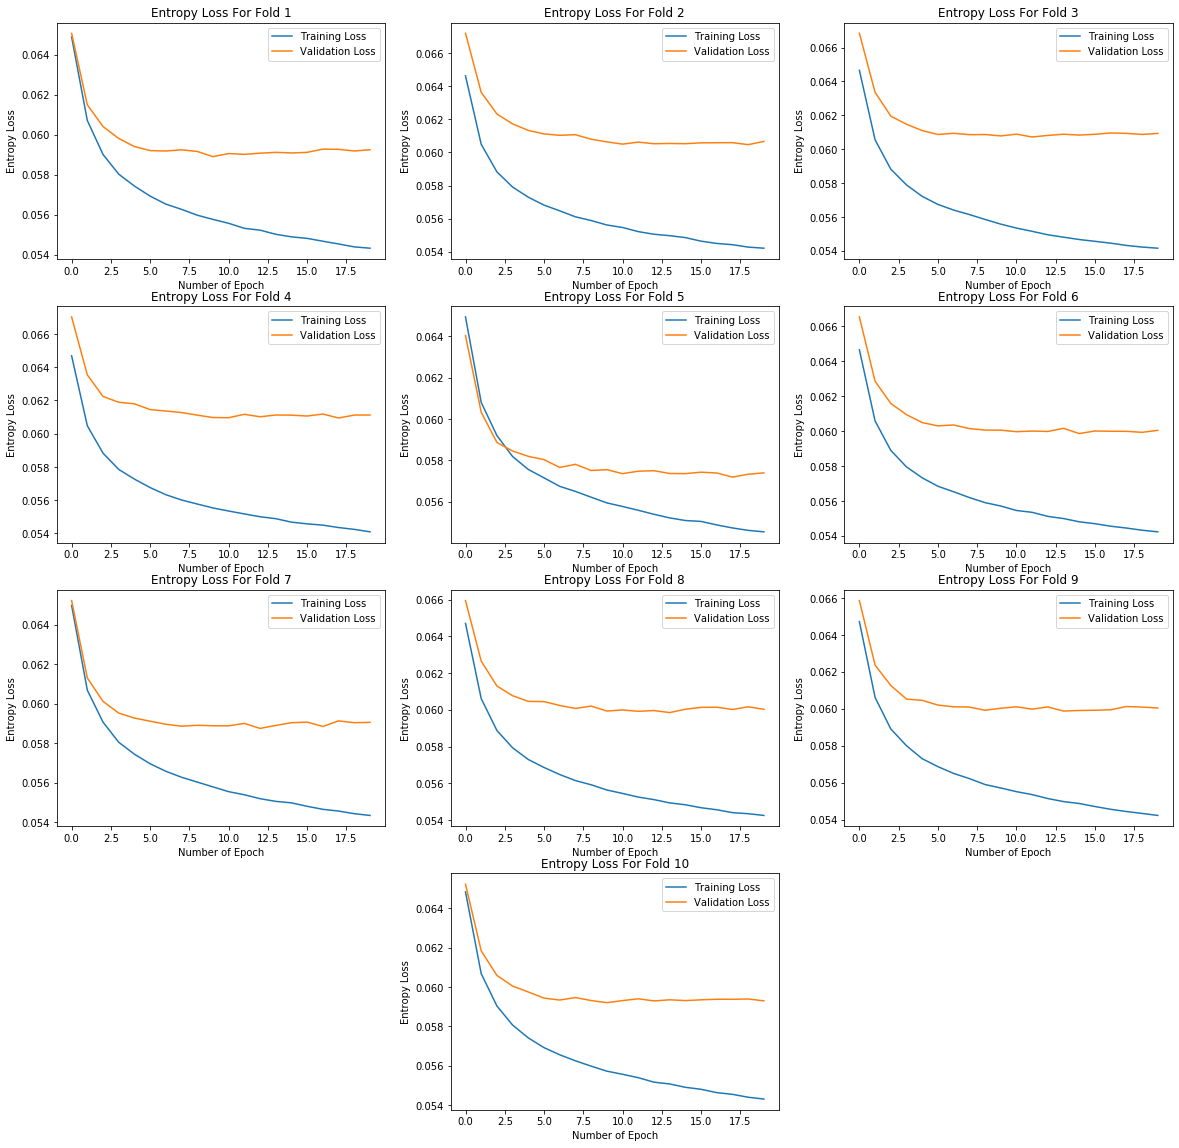

In [115]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 3,figsize=(20,20))


  
ax = axis[0, 0]
ax.plot(lt[:20],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[:20], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 1")  # Add a title to the axes.
ax.legend();  # Add a legend.
  
ax = axis[0, 1]
ax.plot(lt[20:40],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[20:40], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 2")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[0, 2]
ax.plot(lt[40:60],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[40:60], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 3")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 0]
ax.plot(lt[60:80],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[60:80], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 4")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 1]
ax.plot(lt[80:100],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[80:100], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 5")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 2]
ax.plot(lt[100:120],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[100:120], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 6")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 0]
ax.plot(lt[120:140],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[120:140], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 7")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 1]
ax.plot(lt[140:160],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[140:160], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 8")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 2]
ax.plot(lt[160:180],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[160:180], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 9")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[3, 1]
ax.plot(lt[180:],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[180:], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 10")  # Add a title to the axes.
ax.legend();  # Add a legend.

axis[3,0].set_axis_off()
axis[3,2].set_axis_off()
# Combine all the operations and display
plt.show()

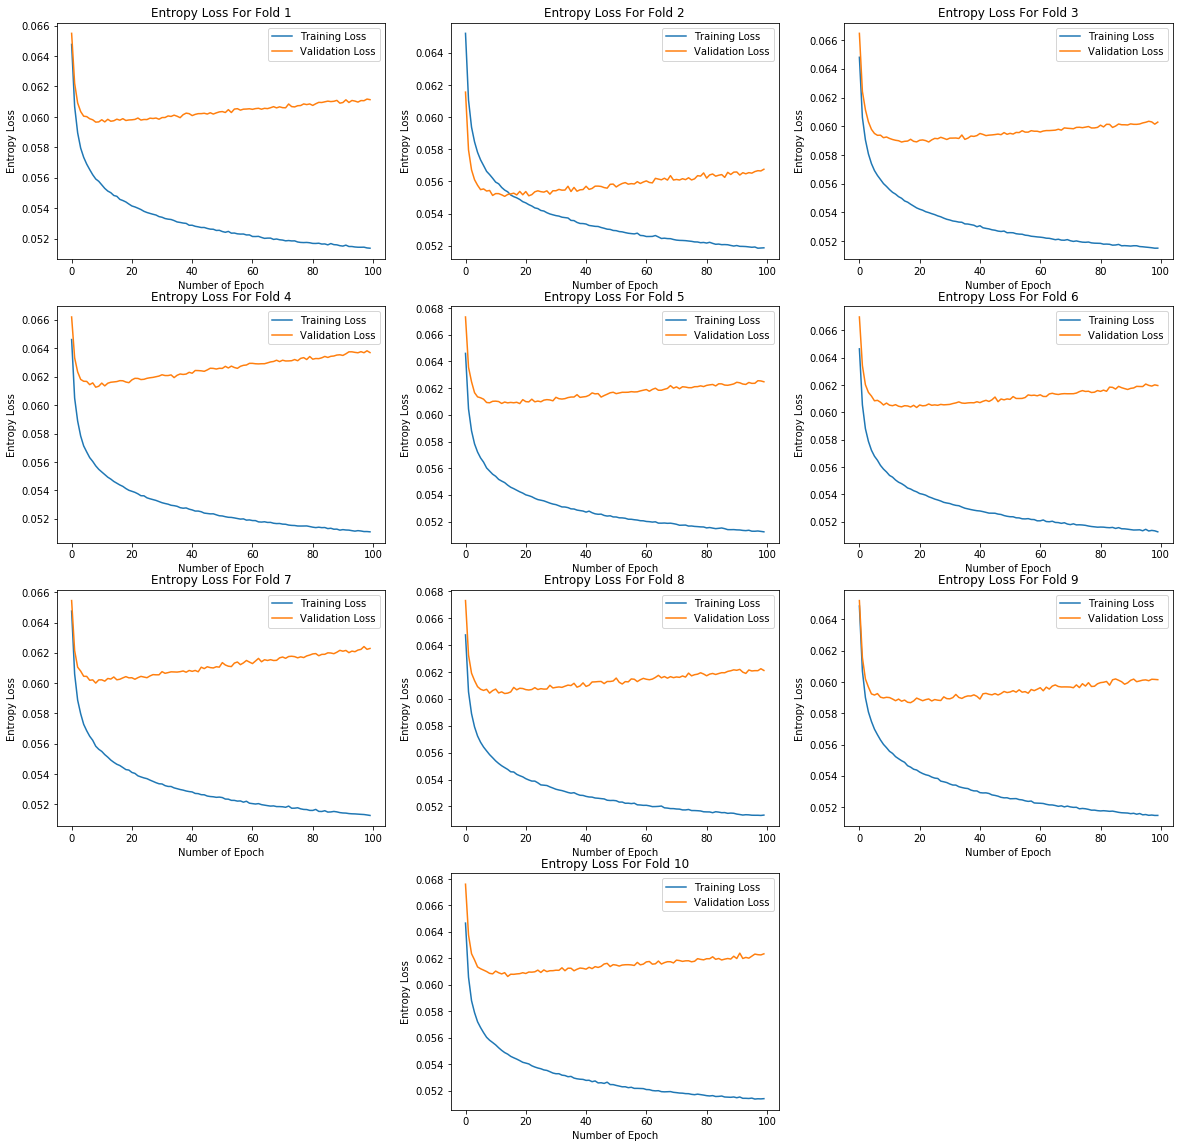

In [80]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 3,figsize=(20,20))


  
ax = axis[0, 0]
ax.plot(lt[:100],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[:100], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 1")  # Add a title to the axes.
ax.legend();  # Add a legend.
  
ax = axis[0, 1]
ax.plot(lt[100:200],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[100:200], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 2")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[0, 2]
ax.plot(lt[200:300],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[200:300], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 3")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 0]
ax.plot(lt[300:400],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[300:400], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 4")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 1]
ax.plot(lt[400:500],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[400:500], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 5")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[1, 2]
ax.plot(lt[500:600],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[500:600], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 6")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 0]
ax.plot(lt[600:700],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[600:700], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 7")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 1]
ax.plot(lt[700:800],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[700:800], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 8")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[2, 2]
ax.plot(lt[800:900],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[800:900], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 9")  # Add a title to the axes.
ax.legend();  # Add a legend.

ax = axis[3, 1]
ax.plot(lt[900:],label='Training Loss')  # Plot some data on the axes.
ax.plot(lv[900:], label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Entropy Loss')  # Add a y-label to the axes.
ax.set_title("Entropy Loss For Fold 10")  # Add a title to the axes.
ax.legend();  # Add a legend.

axis[3,0].set_axis_off()
axis[3,2].set_axis_off()
# Combine all the operations and display
plt.show()

#### 

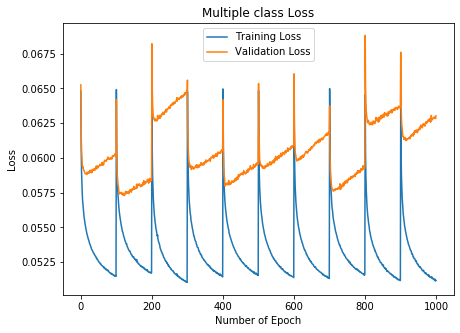

In [133]:
import matplotlib.pyplot as plt
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(7, 5),)
ax.plot(lt,label='Training Loss')  # Plot some data on the axes.
ax.plot(lv, label='Validation Loss')  # Plot more data on the axes...
ax.set_xlabel('Number of Epoch')  # Add an x-label to the axes.
ax.set_ylabel('Loss')  # Add a y-label to the axes.
ax.set_title("Multiple class Loss")  # Add a title to the axes.
ax.legend();  # Add a legend.

In [118]:
t,b,c = softmax_regression.test(test)

In [119]:
t

0.7034

In [124]:
c.shape

(785, 10)

In [120]:
c[:-1,0].shape

(784,)

Text(0.5, 1.0, '5 X 5')

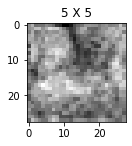

In [121]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.figure() # create a figure with the default size 
im1 = np.random.rand(100,100)
ax1 = fig1.add_subplot(2,2,1) 
ax1.imshow(c[:-1,0].reshape(28, 28), cmap='gray')
ax1.set_title('5 X 5')

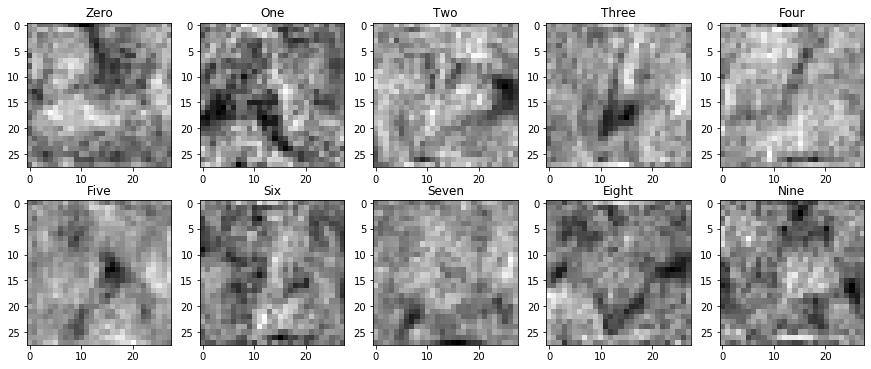

In [122]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 5,figsize=(15,6))

  
axis[0, 0].imshow(c[:-1,0].reshape(28, 28), cmap='gray')
axis[0, 0].set_title("Zero")
  
axis[0, 1].imshow(c[:-1,1].reshape(28, 28), cmap='gray')
axis[0, 1].set_title("One")

axis[0, 2].imshow(c[:-1,2].reshape(28, 28), cmap='gray')
axis[0, 2].set_title("Two")

axis[0, 3].imshow(c[:-1,3].reshape(28, 28), cmap='gray')
axis[0, 3].set_title("Three")

axis[0, 4].imshow(c[:-1,4].reshape(28, 28), cmap='gray')
axis[0, 4].set_title("Four")

axis[1, 0].imshow(c[:-1,5].reshape(28, 28), cmap='gray')
axis[1, 0].set_title("Five")

axis[1, 1].imshow(c[:-1,6].reshape(28, 28), cmap='gray')
axis[1, 1].set_title("Six")

axis[1, 2].imshow(c[:-1,7].reshape(28, 28), cmap='gray')
axis[1, 2].set_title("Seven")

axis[1, 3].imshow(c[:-1,8].reshape(28, 28), cmap='gray')
axis[1, 3].set_title("Eight")

axis[1, 4].imshow(c[:-1,9].reshape(28, 28), cmap='gray')
axis[1, 4].set_title("Nine")
  
# Combine all the operations and display
plt.show()

In [109]:
patterns, labels = load_data(False)

In [110]:
patterns,e,ee = z_score_normalize(patterns)

In [111]:
patterns.shape

(10000, 784)

In [112]:
zero = patterns[np.where(labels==0)][0]
one = patterns[np.where(labels==1)][0]
two = patterns[np.where(labels==2)][0]
three = patterns[np.where(labels==3)][0]
four = patterns[np.where(labels==4)][0]
five= patterns[np.where(labels==5)][0]
six= patterns[np.where(labels==6)][0]
seven= patterns[np.where(labels==7)][0]
eight= patterns[np.where(labels==8)][0]
nine= patterns[np.where(labels==9)][0]

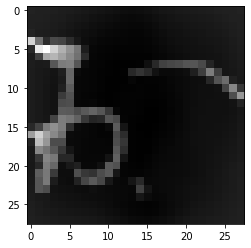

In [116]:
im = plt.imshow(zero.reshape(28, 28), cmap='gray')
plt.colorbar(im)
fig.savefig('1.png', dpi=300)

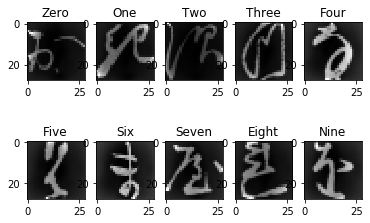

In [113]:

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 5)

fig.set_size_inches(30, 10.5, forward=True)
  
axis[0, 0].imshow(zero.reshape(28, 28), cmap='gray')
axis[0, 0].set_title("Zero")
  
axis[0, 1].imshow(one.reshape(28, 28), cmap='gray')
axis[0, 1].set_title("One")

axis[0, 2].imshow(two.reshape(28, 28), cmap='gray')
axis[0, 2].set_title("Two")

axis[0, 3].imshow(three.reshape(28, 28), cmap='gray')
axis[0, 3].set_title("Three")

axis[0, 4].imshow(four.reshape(28, 28), cmap='gray')
axis[0, 4].set_title("Four")

axis[1, 0].imshow(five.reshape(28, 28), cmap='gray')
axis[1, 0].set_title("Five")

axis[1, 1].imshow(six.reshape(28, 28), cmap='gray')
axis[1, 1].set_title("Six")

axis[1, 2].imshow(seven.reshape(28, 28), cmap='gray')
axis[1, 2].set_title("Seven")

axis[1, 3].imshow(eight.reshape(28, 28), cmap='gray')
axis[1, 3].set_title("Eight")

axis[1, 4].imshow(nine.reshape(28, 28), cmap='gray')
axis[1, 4].set_title("Nine")
  
# Combine all the operations and display
plt.show()